# Next-Word Prediction Using Long Short-Term Memory (LSTM) Networks

Implement the model that will predict the next word in a text sequence and train it using a corpus of [Shakespeare Sonnets](https://www.opensourceshakespeare.org/views/sonnets/sonnet_view.php?range=viewrange&sonnetrange1=1&sonnetrange2=154)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle

## Defining global variables

Define some global variables that will be used throughout the project.

- `FILE_PATH`: The file path where the sonnets file is located.

- `NUM_BATCHES`: Number of batches. Defaults to 16.
- `LSTM_UNITS`: Number of LSTM units in the LSTM layer.
- `EMBEDDING_DIM`: Number of dimensions in the embedding layer.

In [2]:
FILE_PATH = 'sonnets1.txt'
NUM_BATCHES = 16
LSTM_UNITS = 128
EMBEDDING_DIM = 100

### Reading the dataset

For this project you will be using the [Shakespeare Sonnets Dataset](https://www.opensourceshakespeare.org/views/sonnets/sonnet_view.php?range=viewrange&sonnetrange1=1&sonnetrange2=154), which contains more than 2000 lines of text extracted from Shakespeare's sonnets.

In [3]:
# Read the data
with open(FILE_PATH) as f:
    data = f.read()

# Convert to lower case and save as a list
corpus = data.lower().split("\n")

print(f"There are {len(corpus)} lines of sonnets\n")
print(f"The first 5 lines look like this:\n")
for i in range(5):
  print(corpus[i])

There are 2465 lines of sonnets

The first 5 lines look like this:

from fairest creatures we desire increase,
that thereby beauty's rose might never die,
but as the riper should by time decease,
his tender heir might bear his memory:
but thou contracted to thine own bright eyes,


## 1: fit_vectorizer

You will use the [tf.keras.layers.TextVectorization layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) to tokenize and transform the text into numeric values.

**Note**:
- You should remove the punctuation and use only lowercase words, so you must pass the correct argument to TextVectorization layer.




In [11]:
def fit_vectorizer(corpus):
    """
    Instantiates the vectorizer class on the corpus

    Args:
        corpus (list): List with the sentences.

    Returns:
        (tf.keras.layers.TextVectorization): an instance of the TextVectorization class containing the word-index dictionary, adapted to the corpus sentences.
    """

    tf.keras.utils.set_random_seed(65) # Do not change this line or you may have different expected outputs throughout the assignment

    ### START CODE HERE ###

     # Define the object with appropriate parameters
    vectorizer =tf.keras.layers.TextVectorization(
        standardize= 'lower_and_strip_punctuation', # Convert to lowercase and strip punctuation
        split='whitespace',               # Split on whitespace (default)
        ragged=True,             # Allow ragged tensors
        output_mode='int'               # Output as integers
    )

    # Adapt it to the corpus
    vectorizer.adapt(corpus)
    ### END CODE HERE ###

    return vectorizer

In [12]:
vectorizer = fit_vectorizer(corpus)
total_words = len(vectorizer.get_vocabulary())
print('Name: R Guruprasad Register Number:212222240033 ')
print(f"Total number of words in corpus (including the out of vocabulary): {total_words}")

Name: R Guruprasad Register Number:212222240033 
Total number of words in corpus (including the out of vocabulary): 3180


One thing to note is that you can either pass a string or a list of strings to vectorizer. If you pass the former, it will return a *tensor* whereas if you pass the latter, it will return a *ragged tensor* if you've correctly configured the TextVectorization layer to do so.

In [13]:
print('Name:R Guruprasad Register Number:212222240033')
print(f"Passing a string directly: {vectorizer('This is a test string').__repr__()}")
print(f"Passing a list of strings: {vectorizer(['This is a test string'])}")

Name:R Guruprasad Register Number:212222240033
Passing a string directly: <tf.Tensor: shape=(5,), dtype=int64, numpy=array([  30,   14,   18,    1, 1688])>
Passing a list of strings: <tf.RaggedTensor [[30, 14, 18, 1, 1688]]>


## Generating n-grams

## 2: n_grams_seqs

Complete the `n_gram_seqs` function below. This function receives the fitted vectorizer and the corpus (which is a list of strings) and should return a list containing the `n_gram` sequences for each line in the corpus.

**NOTE:**

- If you pass `vectorizer(sentence)` the result is not padded, whereas if you pass `vectorizer(list_of_sentences)`, the result won't be padded **only if you passed the argument `ragged = True`** in the TextVectorization setup.

In [14]:
def n_gram_seqs(corpus, vectorizer):
    """
    Generates a list of n-gram sequences

    Args:
        corpus (list of string): lines of texts to generate n-grams for
        vectorizer (tf.keras.layers.TextVectorization): an instance of the TextVectorization class adapted in the corpus

    Returns:
        (list of tf.int64 tensors): the n-gram sequences for each line in the corpus
    """
    input_sequences = []

    ### START CODE HERE ###
    for sentence in corpus:
        # Vectorize the sentence to get the token indices
        vectorized_sentence =vectorizer(sentence)

        # Generate n-grams for the vectorized sentence
        for i in range(2,len(vectorized_sentence)+1):  # Start from 2 to avoid the first token
            n_gram =vectorized_sentence[:i]
            input_sequences.append(n_gram)

    ### END CODE HERE ###

    return input_sequences

Apply the `n_gram_seqs` transformation to the whole corpus and save the maximum sequence length to use it later:

In [17]:
# Apply the n_gram_seqs transformation to the whole corpus
input_sequences = n_gram_seqs(corpus, vectorizer)

# Save max length
max_sequence_len = max([len(x) for x in input_sequences])
print('Name: R Guruprasad Register Number:212222240033 ')
print(f"n_grams of input_sequences have length: {len(input_sequences)}")
print(f"maximum length of sequences is: {max_sequence_len}")

Name: R Guruprasad Register Number:212222240033 
n_grams of input_sequences have length: 15428
maximum length of sequences is: 11


## 3: pad_seqs

Now code the `pad_seqs` function which will pad any given sequences to the desired maximum length. Notice that this function receives a list of sequences and should return a numpy array with the padded sequences. You may have a look at the documentation of [`tf.keras.utils.pad_sequences`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences).



In [24]:
def pad_seqs(input_sequences, max_sequence_len):
    """
    Pads tokenized sequences to the same length

    Args:
        input_sequences (list of int): tokenized sequences to pad
        maxlen (int): maximum length of the token sequences

    Returns:
        (np.array of int32): tokenized sequences padded to the same length
    """

   ### START CODE HERE ###
    # Convert tensors to lists if necessary
    input_list = [seq if isinstance(seq, list) else seq.numpy().tolist() for seq in input_sequences]

    # Use pad_sequences to pad the sequences with left padding ('pre')
    padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(
        input_sequences,
        maxlen=max_sequence_len,
        padding='pre',
        dtype='int32'
                     # Use the list of lists for padding
                     # Set the maximum length
                     # Pad sequences to the left (before the sequence)
                     # Specify the output type as int32
    )
    ### END CODE HERE ###

    return padded_sequences

In [27]:
# Pad the whole corpus
#input_sequences = pad_seqs(input_sequences, max_sequence_len)
print('Name: R Guruprasad Register Number:212222240033')
print(f"padded corpus has shape: {input_sequences.shape}")

Name: R Guruprasad Register Number:212222240033
padded corpus has shape: (15428, 11)


## 4: features_and_labels_dataset

Before feeding the data into the neural network you should split it into features and labels. In this case the features will be the *padded n_gram sequences* with the **last element** removed from them and the labels will be the removed words.

Complete the `features_and_labels_dataset` function below. This function expects the `padded n_gram sequences` as input and should return a **batched** [tensorflow dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) containing elements in the form (sentence, label).


**NOTE**:
- Notice that the function also receives the total of words in the corpus, this parameter will be **very important when one hot encoding the labels** since every word in the corpus will be a label at least once. The function you should use is [`tf.keras.utils.to_categorical`]((https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical)).
- To generate a dataset you may use the function [tf.data.Dataset.from_tensor_slices](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices) after obtaining the sentences and their respective labels.
- To batch a dataset, you may call the method [.batch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch). A good number is `16`, but feel free to choose any number you want to, but keep it not greater than 64, otherwise the model may take too many epochs to achieve a good accuracy. Remember this is defined as a global variable.

In [28]:
def features_and_labels_dataset(input_sequences, total_words):
    """
    Generates features and labels from n-grams and returns a tensorflow dataset

    Args:
        input_sequences (list of int): sequences to split features and labels from
        total_words (int): vocabulary size

    Returns:
        (tf.data.Dataset): Dataset with elements in the form (sentence, label)
    """
    ### START CODE HERE ###
    # Define the features by taking all tokens except the last one for each sequence
    features =input_sequences[:,:-1]

    # Define the labels by taking the last token for each sequence
    labels =input_sequences[:,-1]

    # One-hot encode the labels using total_words as the number of classes
    one_hot_labels =tf.keras.utils.to_categorical(labels, num_classes=total_words)

    # Build the dataset using the features and one-hot encoded labels
    dataset = tf.data.Dataset.from_tensor_slices((features, one_hot_labels))

    # Batch the dataset with a batch size of 16
    batch_size = 16  # Feel free to adjust this based on the global variable, but should be <= 64
    batched_dataset = dataset.batch(batch_size)

    ### END CODE HERE ###

    return batched_dataset

In [30]:
# Split the whole corpus
dataset = features_and_labels_dataset(input_sequences, total_words).prefetch(tf.data.AUTOTUNE)
print('Name:R Guruprasad Register Number: 212222240033 ')
print(f"Feature shape: {dataset.element_spec[0]}")
print(f"Label shape: {dataset.element_spec[1]}")

Name:R Guruprasad Register Number: 212222240033 
Feature shape: TensorSpec(shape=(None, 10), dtype=tf.int32, name=None)
Label shape: TensorSpec(shape=(None, 3180), dtype=tf.float64, name=None)


## 5: create_model

Now you should define a model architecture capable of achieving an accuracy of at least 80%.

Some hints to help you in this task:

- The first layer in your model must be an [Input](https://www.tensorflow.org/api_docs/python/tf/keras/Input) layer with the appropriate parameters, remember that your input are vectors with a fixed length size. Be careful with the size value you should pass as you've removed the last element of every input to be the label.

- An appropriate `output_dim` for the first layer (Embedding) is 100, this is already provided for you.
- A Bidirectional LSTM is helpful for this particular problem.
- The last layer should have the same number of units as the total number of words in the corpus and a softmax activation function.
- This problem can be solved with only two layers (excluding the Embedding and Input) so try out small architectures first.
- 30 epochs should be enough to get an accuracy higher than 80%, if this is not the case try changing the architecture of your model.

In [31]:
def create_model(total_words, max_sequence_len):
    """
    Creates a text generator model

    Args:
        total_words (int): size of the vocabulary for the Embedding layer input
        max_sequence_len (int): length of the input sequences

    Returns:
       (tf.keras Model): the text generator model
    """
    model = tf.keras.Sequential()

   ### START CODE HERE ###
    # Input layer shape is max_sequence_len - 1 because we removed the last word as a label
    model.add(tf.keras.layers.Input(shape=(max_sequence_len - 1,)))

    # Embedding layer
    model.add(tf.keras.layers.Embedding(input_dim=total_words, output_dim=100, input_length=max_sequence_len - 1))

    # Add a Bidirectional LSTM layer with 150 units
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)))

    # Add a Dense layer with 'total_words' units and softmax activation
    model.add(tf.keras.layers.Dense(total_words, activation='softmax'))

    # Compile the model
    model.compile(loss='categorical_crossentropy',  # Loss function for multi-class classification
                  optimizer='adam',                 # Adam optimizer
                  metrics=['accuracy'])
    ### END CODE HERE ###

    return model

In [32]:
# Get the untrained model
model = create_model(total_words, max_sequence_len)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [33]:
example_batch = dataset.take(1)

try:
	model.evaluate(example_batch, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function and last layer are compatible with one another.")
else:
	predictions = model.predict(example_batch, verbose=False)
	print(f"predictions have shape: {predictions.shape}")

predictions have shape: (16, 3180)


In [34]:
# Train the model
history = model.fit(dataset, epochs=30, verbose=1)

Epoch 1/30
965/965 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.0265 - loss: 7.0320
Epoch 2/30
965/965 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.0303 - loss: 6.1587
Epoch 3/30
965/965 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.0417 - loss: 5.7750
Epoch 4/30
965/965 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.0499 - loss: 5.4706
Epoch 5/30
965/965 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.0591 - loss: 5.2762
Epoch 6/30
965/965 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.0723 - loss: 5.0100
Epoch 7/30
965/965 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.0872 - loss: 4.7486
Epoch 8/30
965/965 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.1148 - loss: 4.4651
Epoch 9/30
965/965 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.1434 - loss: 4.2406
Epoch 10/30
965/965 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.2058 - loss: 3.8644
Epoch 11/30
965/965 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.2682 - loss: 3.5625
Epoch 12/30
965/965 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/

**Your model should achieve a training accuracy of at least 80%**. If your model didn't achieve this threshold, try training again with a different model architecture. Consider increasing the number of units in your `LSTM` layer.

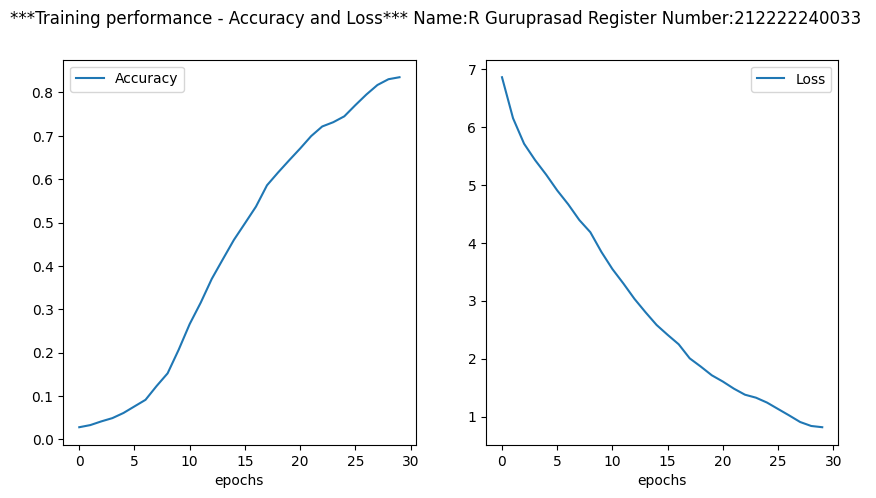

In [35]:
# Get training and validation accuracies
acc = history.history['accuracy']
loss = history.history['loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('***Training performance - Accuracy and Loss*** Name:R Guruprasad Register Number:212222240033 ')

for i, (data, label) in enumerate(zip([acc,loss], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data, label=label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

If the accuracy meets the requirement of being greater than 80%, then save the `history.pkl` file which contains the information of the training history of your model.

In [36]:
with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

## See your model in action

After all your work it is finally time to see your model generating text.

Run the cell below to generate the next 100 words of a seed text.

In [39]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100

for _ in range(next_words):
    # Convert the text into sequences
    token_list = vectorizer(seed_text)
    # Pad the sequences
    token_list = tf.keras.utils.pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    # Get the probabilities of predicting a word
    predicted = model.predict([token_list], verbose=0)
    # Choose the next word based on the maximum probability
    predicted = np.argmax(predicted, axis=-1).item()
    # Get the actual word from the word index
    output_word = vectorizer.get_vocabulary()[predicted]
    # Append to the current text
    seed_text += " " + output_word
print('Name: R Guruprasd Register Number: 212222240033')
seed_text

Name: R Guruprasd Register Number: 212222240033


"Help me Obi Wan Kenobi, you're my only hope out truth string end dateless power god blazon knowst truth among watching vengeful flowers one delight than brow tongue more cold cold new end cruel cold new fast new knowst correspondence saint nobler time under disease young eyes bring forth forth me lily bright glory live young good thoughts cruel say my self still thee bright life lourst dear self bring me dear mind mind mind have prove thee out of all or face of mind thy self away to me still bright more part truth sovereign fears lies power blazon very eye view bright ink gain case best best"